<a href="https://colab.research.google.com/github/Omerliler/Cifar-10_CNN-Classification/blob/main/Cifar_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models,optimizers
import matplotlib.pyplot as plt
import numpy as np

## Getting the data from Keras Datasets

In [2]:
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

In [ ]:
X_train.shape

(50000, 32, 32, 3)

In [ ]:
y_train[:5]

array([[6],
       [9],
       [9],
       [4],
       [1]], dtype=uint8)

In [3]:
y_train = y_train.reshape(-1,)
y_train[:5]

array([6, 9, 9, 4, 1], dtype=uint8)

## Show Image Function

In [4]:
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

def showImage(X,y,index, y_classes=0):
  plt.figure(figsize=(15,2))
  plt.imshow(X[index])
  if(y_classes == 0):
    plt.xlabel('Label: {} - Prediction: {}'.format(classes[y[index]],  'NaN'))
    return
  plt.xlabel('Label: {} - Prediction: {}'.format(classes[y[index]],  classes[y_classes[index]]))

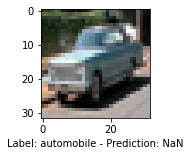

In [ ]:
showImage(X_train,y_train,32)

## Normalizing the data

In [5]:
X_train = X_train/255
X_test = X_test/255

## Hyperparameter Optimization - Keras Tuner


In [ ]:
pip install keras-tuner 

In [ ]:
import keras_tuner as kt
from keras_tuner import RandomSearch


def build_model(hp):
  model = models.Sequential()

  # model.add(layers.AveragePooling2D(6,3,input_shape=(32, 32, 3)))

  for i in range(hp.Int("Conv Layers", min_value=0, max_value=3)):
    model.add(layers.Conv2D(filters=hp.Choice(f"layer_{i}_filters", [4,16,32]), kernel_size=(3,3), activation='relu', input_shape=(32, 32, 3)))
  
  model.add(layers.MaxPooling2D((2,2))),
  model.add(layers.Dropout(0.5))
  model.add(layers.Flatten())

  model.add(layers.Dense(hp.Choice("Dense layer", [32, 64, 128]), activation='relu'))

  model.add(layers.Dense(10, activation='softmax'))

  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model


tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=24,
    overwrite=True
)

tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Trial 24 Complete [00h 01m 50s]
val_accuracy: 0.6549000144004822

Best val_accuracy So Far: 0.675000011920929
Total elapsed time: 00h 46m 20s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_model = tuner.get_best_models()[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 128)               802944    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                        

In [ ]:
tuner.results_summary()

In [ ]:
best_model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 4ms/step - loss: 1.0123 - accuracy: 0.6750


[1.012343406677246, 0.675000011920929]

In [ ]:
y_pred = best_model.predict(X_test)
y_classes = [np.argmax(element) for element in y_pred]
y_test = y_test.reshape(-1,)



In [ ]:
for i in range(10):
  showImage(X_test, y_test, i, y_classes)

## Tuner Class

In [13]:
from keras_tuner import HyperModel


class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = models.Sequential()
        model.add(
            layers.Conv2D(
                filters=16,
                kernel_size=3,
                activation='relu',
                input_shape=self.input_shape
            )
        )
        model.add(
            layers.Conv2D(
                filters=16,
                activation='relu',
                kernel_size=3
            )
        )
        model.add(layers.MaxPooling2D(pool_size=2))
        model.add(
            layers.Dropout(rate=hp.Float(
                'dropout_1',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            ))
        )
        model.add(
            layers.Conv2D(
                filters=32,
                kernel_size=3,
                activation='relu'
            )
        )
        model.add(
            layers.Conv2D(
                filters=hp.Choice(
                    'num_filters',
                    values=[32, 64],
                    default=64,
                ),
                activation='relu',
                kernel_size=3
            )
        )
        model.add(layers.MaxPooling2D(pool_size=2))
        model.add(
            layers.Dropout(rate=hp.Float(
                'dropout_2',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            ))
        )
        model.add(layers.Flatten())
        model.add(
            layers.Dense(
                units=hp.Int(
                    'units',
                    min_value=32,
                    max_value=512,
                    step=32,
                    default=128
                ),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'
                )
            )
        )
        model.add(
            layers.Dropout(
                rate=hp.Float(
                    'dropout_3',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05
                )
            )
        )
        model.add(layers.Dense(self.num_classes, activation='softmax'))

        model.compile(
            optimizer=optimizers.Adam(
                hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )
            ),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model
INPUT_SHAPE = (32,32,3)
NUM_CLASSES = 10
hypermodel = CNNHyperModel(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)

MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 2

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='random_search',
    project_name='cifar10'
)

In [ ]:
tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=20)

Trial 6 Complete [00h 09m 05s]
val_accuracy: 0.2988999970257282

Best val_accuracy So Far: 0.7215000092983246
Total elapsed time: 00h 59m 20s

Search: Running Trial #7

Hyperparameter    |Value             |Best Value So Far 
dropout_1         |0.15              |0.3               
num_filters       |32                |64                
dropout_2         |0.2               |0.05              
units             |128               |192               
dense_activation  |tanh              |relu              
dropout_3         |0.1               |0                 
learning_rate     |0.0016084         |0.00013786        



In [ ]:
best_model = tuner.get_best_models()[0]
best_model.summary()